# Business data science for airline customer satisfaction

We are using this dataset:

https://www.openml.org/search?type=data&status=active&id=46920

### Imports

In [1]:
!uv pip install scikit-learn pandas seaborn matplotlib numpy hdbscan umap-learn -q

In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Part 1: Exploratory data analysis

### Exploratory data analysis (EDA)

In [3]:
# we retrieve our dataset using sklearn
data = fetch_openml(data_id=46920, as_frame=True)

df = data.frame #we want the full dataframe (features + target if present)
df.head()

,satisfaction,CustomerType,Age,TypeofTravel,Class,FlightDistance,Seatcomfort,DepartureArrivaltimeconvenient,Foodanddrink,Gatelocation,...,Onlinesupport,EaseofOnlinebooking,Onboardservice,Legroomservice,Baggagehandling,Checkinservice,Cleanliness,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes
0,dissatisfied,disloyal Customer,20,Business travel,Eco,2069,4,4,4,3,...,5,5,4,5,3,2,4,5,0,7.0
1,dissatisfied,Loyal Customer,48,Personal Travel,Eco,2329,2,4,2,3,...,1,1,1,5,3,1,2,1,0,0.0
2,dissatisfied,Loyal Customer,24,Business travel,Eco,1273,1,1,0,3,...,5,5,2,2,2,2,2,5,0,8.0
3,satisfied,disloyal Customer,28,Business travel,Business,2306,4,4,4,1,...,3,3,4,5,5,4,4,3,72,80.0
4,satisfied,Loyal Customer,49,Business travel,Business,1545,4,4,4,4,...,4,5,5,5,5,5,5,3,0,0.0


#### Getting to know the shape of the df and it's different columns (features)

In [4]:
df.shape

(129880, 22)

In [5]:
df.columns

Index(['satisfaction', 'CustomerType', 'Age', 'TypeofTravel', 'Class',
       'FlightDistance', 'Seatcomfort', 'DepartureArrivaltimeconvenient',
       'Foodanddrink', 'Gatelocation', 'Inflightwifiservice',
       'Inflightentertainment', 'Onlinesupport', 'EaseofOnlinebooking',
       'Onboardservice', 'Legroomservice', 'Baggagehandling', 'Checkinservice',
       'Cleanliness', 'Onlineboarding', 'DepartureDelayinMinutes',
       'ArrivalDelayinMinutes'],
      dtype='object')

#### Some basic EDA, finding correlations and basic statistics about the already numerical data before any modifications

In [6]:
len(df)

129880

In [7]:
#we check to see if there are any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   satisfaction                    129880 non-null  category
 1   CustomerType                    129880 non-null  category
 2   Age                             129880 non-null  int64   
 3   TypeofTravel                    129880 non-null  category
 4   Class                           129880 non-null  category
 5   FlightDistance                  129880 non-null  int64   
 6   Seatcomfort                     129880 non-null  category
 7   DepartureArrivaltimeconvenient  129880 non-null  category
 8   Foodanddrink                    129880 non-null  category
 9   Gatelocation                    129880 non-null  category
 10  Inflightwifiservice             129880 non-null  category
 11  Inflightentertainment           129880 non-null  category
 12  On

No missing values in any category but the last, "$ArrivalDelayinMinutes$"

In [8]:
#we do some analysis of the different columns, taking only those with numerical values into account
df.describe()

,Age,FlightDistance,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1981.409055,3.352587,14.713713,15.091129
std,15.119360,1027.115606,1.298715,38.071126,38.465650
min,7.000000,50.000000,0.000000,0.000000,0.000000
25%,27.000000,1359.000000,2.000000,0.000000,0.000000
50%,40.000000,1925.000000,4.000000,0.000000,0.000000
75%,51.000000,2544.000000,4.000000,12.000000,13.000000
max,85.000000,6951.000000,5.000000,1592.000000,1584.000000


What we get from this:
* Mean age is ~40 years old
  * Age generally ranges from 27 to 51, with a 15 years standard deviation

* The average flight goes for 2000 km
  * Flight length generally ranges from 1360 to 2544 km, with a 1030 km standard deviation

* There is a ~15 minutes delay in departure time on average, with a high standard deviation of ~40 minutes
  * This is not normally distributed, as the median flight delay in departure time is 0
  * Some outliers account for most of the departure delay
    * We can infer that when there's a delay, it's a big one

* The same analysis can be done about the arrival delay


Next, we use the $pairplot$ function of seaborn, which creates a matrix of scatterplots, showing pairwise relationships between variables in our dataset, to help us visualize correlations and distributions

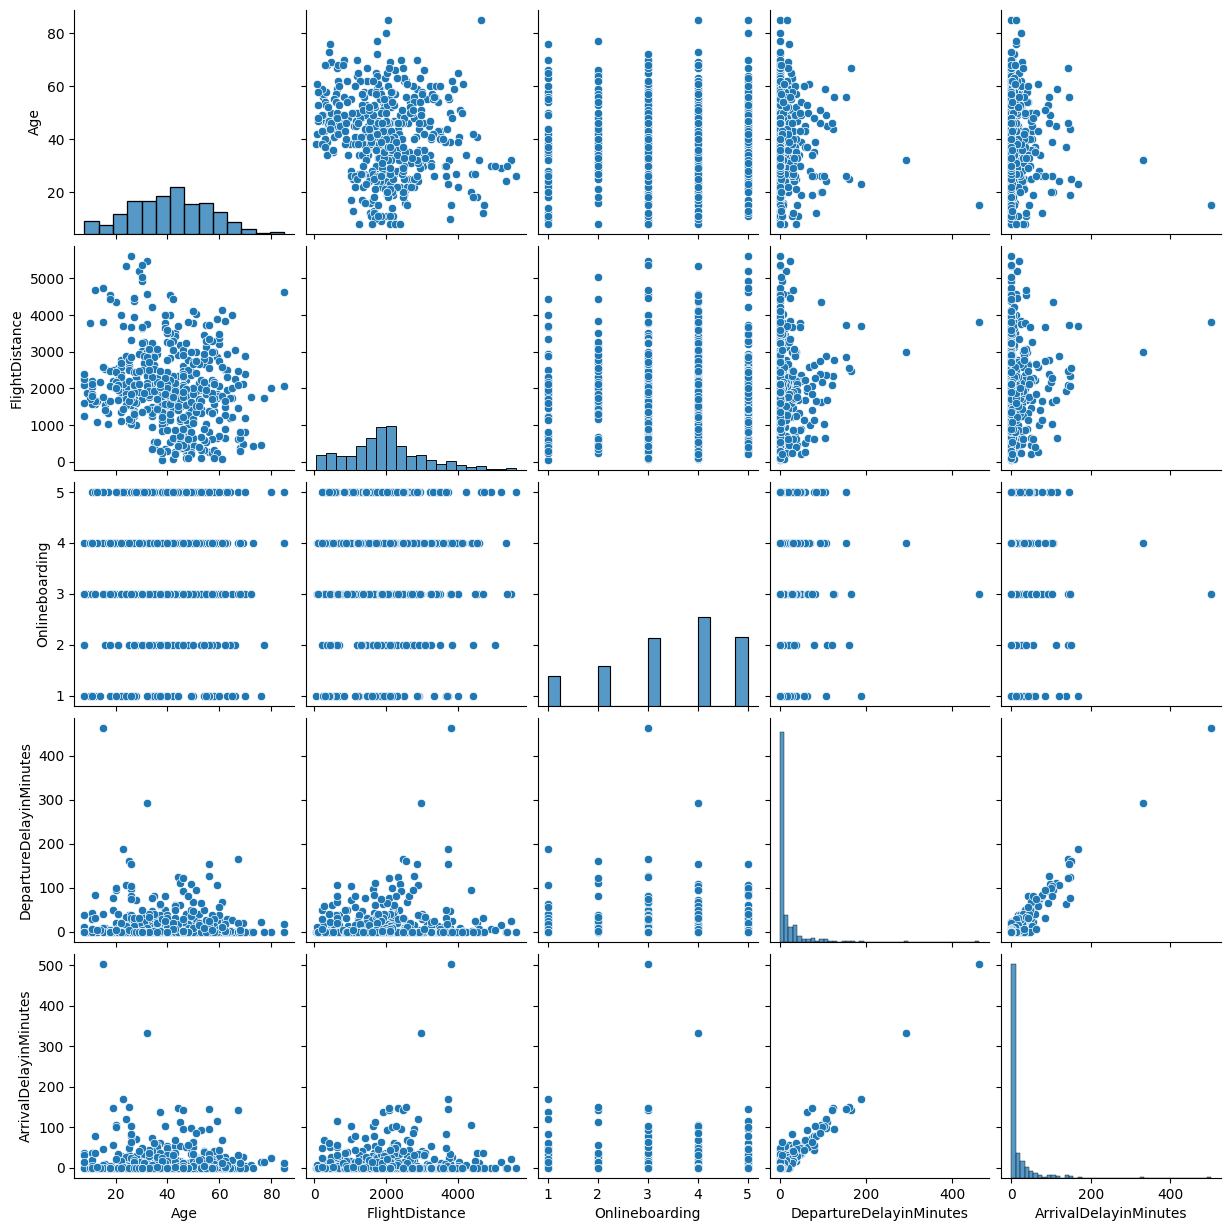

In [9]:
# we do our analysis on a sample otherwise to make it easier to run. 500 data points instead of the 129880
sns.pairplot(df.sample(500))
plt.show()

While all those are not relevant, it is interesting to note that these seem to be correlated:
* Arrival delay and departure delay
* Age and flight distance (less obvious, but we can interpolate a trend)

To follow on our intuition, we will do a correlation analysis.

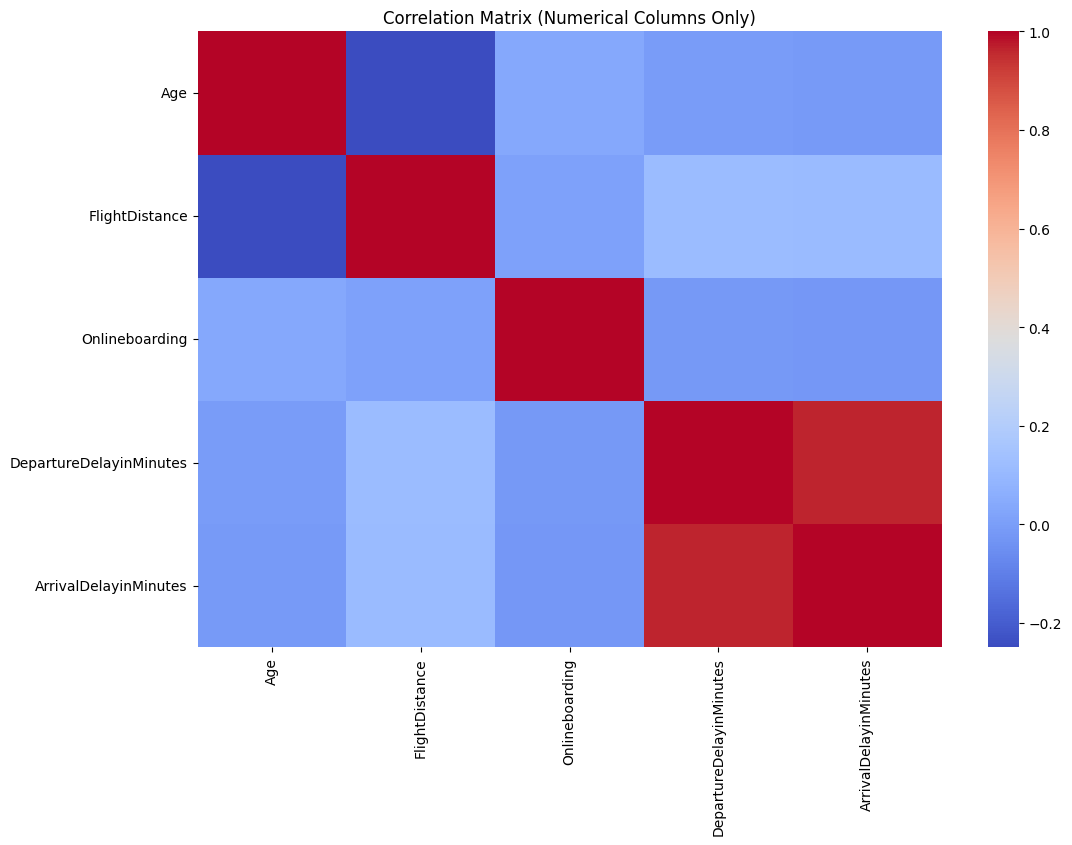

In [10]:
#now, we'll do a correlation analysis. For that, we need to filter to only have numerical columns to avoid any errors:

#select only numeric columns
numeric_df = df.select_dtypes(include="number")

#compute correlation
corr = numeric_df.corr()

#plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix (Numerical Columns Only)")
plt.show()

In [11]:
corr

,Age,FlightDistance,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes
Age,1.000000,-0.249625,0.037973,-0.009041,-0.011248
FlightDistance,-0.249625,1.000000,0.009604,0.112555,0.110103
Onlineboarding,0.037973,0.009604,1.000000,-0.020045,-0.021784
DepartureDelayinMinutes,-0.009041,0.112555,-0.020045,1.000000,0.965291
ArrivalDelayinMinutes,-0.011248,0.110103,-0.021784,0.965291,1.000000


In [12]:
#to read the above correlation table better, we filter to only keep values above a certain arbitrary threshold
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_threshold = 0.2
strong_corr = upper[(upper.abs() >corr_threshold)].stack().sort_values(ascending=False)
print(f"Strong correlations (|corr| > {corr_threshold}):")
print(strong_corr)

Strong correlations (|corr| > 0.2):
DepartureDelayinMinutes  ArrivalDelayinMinutes    0.965291
Age                      FlightDistance          -0.249625
dtype: float64


As we can see, the departure and arrival delays are almost perfectly correlated.

There also exists a negative correlation between age and flight distance, though it is quite weak, as it is only a ~0.25 correlation, below the  0.5 correlated mark which is required to call it significant.

#### Moving on to analyzing the data and transforming it to numerical values (close this markdown for easier access to the rest of the analysis)

In [13]:
df.columns

Index(['satisfaction', 'CustomerType', 'Age', 'TypeofTravel', 'Class',
       'FlightDistance', 'Seatcomfort', 'DepartureArrivaltimeconvenient',
       'Foodanddrink', 'Gatelocation', 'Inflightwifiservice',
       'Inflightentertainment', 'Onlinesupport', 'EaseofOnlinebooking',
       'Onboardservice', 'Legroomservice', 'Baggagehandling', 'Checkinservice',
       'Cleanliness', 'Onlineboarding', 'DepartureDelayinMinutes',
       'ArrivalDelayinMinutes'],
      dtype='object')

##### We convert the data from non-numerical columns into numerical values

###### satisfaction

In [14]:
df["satisfaction"].unique()

['dissatisfied', 'satisfied']
Categories (2, object): ['dissatisfied', 'satisfied']

In [15]:
df["satisfaction"]

0         dissatisfied
1         dissatisfied
2         dissatisfied
3            satisfied
4            satisfied
              ...     
129875       satisfied
129876       satisfied
129877       satisfied
129878       satisfied
129879       satisfied
Name: satisfaction, Length: 129880, dtype: category
Categories (2, object): ['dissatisfied', 'satisfied']

We only have two values for the satisfaction, so we turn it into:
* 0 if the customer is dissatisfied
* 1 if the customer is satisfied

In [16]:
df['satisfaction'] = df['satisfaction'].map({'dissatisfied': 0,'satisfied': 1}).astype('int')

In [17]:
df["satisfaction"]

0         0
1         0
2         0
3         1
4         1
         ..
129875    1
129876    1
129877    1
129878    1
129879    1
Name: satisfaction, Length: 129880, dtype: int64

In [18]:
df["satisfaction"].unique()

array([0, 1])

###### We now do the same for all other columns which do not contain numeric values, or which aren't picked up as being numeric values

###### TypeofTravel

In [19]:
df["TypeofTravel"].unique()

['Business travel', 'Personal Travel']
Categories (2, object): ['Business travel', 'Personal Travel']

In [20]:
df['TypeofTravel'] = df['TypeofTravel'].map({'Business travel': 0,'Personal Travel': 1}).astype('int')

In [21]:
df['TypeofTravel'].unique()

array([0, 1])

###### Class

In [22]:
df["Class"].unique()

['Eco', 'Business', 'Eco Plus']
Categories (3, object): ['Eco Plus', 'Business', 'Eco']

In [23]:
df['Class'] = df['Class'].map({'Eco': 0,'Business': 1,'Eco Plus': 2}).astype('int')

In [24]:
df["Class"].unique()

array([0, 1, 2])

###### Seatcomfort

In [25]:
df["Seatcomfort"].unique()

['4', '2', '1', '0', '3', '5']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [26]:
df["Seatcomfort"] = pd.to_numeric(df["Seatcomfort"])

In [27]:
df["Seatcomfort"].unique()

array([4, 2, 1, 0, 3, 5])

###### DepartureArrivaltimeconvenient

In [28]:
df["DepartureArrivaltimeconvenient"].unique()

['4', '1', '5', '3', '2', '0']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [29]:
df["DepartureArrivaltimeconvenient"] = pd.to_numeric(df["DepartureArrivaltimeconvenient"])

In [30]:
df["DepartureArrivaltimeconvenient"].unique()

array([4, 1, 5, 3, 2, 0])

###### Foodanddrink

In [31]:
df["Foodanddrink"].unique()

['4', '2', '0', '5', '3', '1']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [32]:
df["Foodanddrink"] = pd.to_numeric(df["Foodanddrink"])

In [33]:
df["Foodanddrink"].unique()

array([4, 2, 0, 5, 3, 1])

###### Gatelocation

In [34]:
df["Gatelocation"].unique()

['3', '1', '4', '5', '2', '0']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [35]:
df["Gatelocation"] = pd.to_numeric(df["Gatelocation"])

In [36]:
df["Gatelocation"].unique()

array([3, 1, 4, 5, 2, 0])

###### Inflightwifiservice

In [37]:
df["Inflightwifiservice"].unique()

['5', '1', '3', '2', '4', '0']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [38]:
df["Inflightwifiservice"] = pd.to_numeric(df["Inflightwifiservice"])

In [39]:
df["Inflightwifiservice"].unique()

array([5, 1, 3, 2, 4, 0])

###### Inflightentertainment

In [40]:
df["Inflightentertainment"].unique()

['4', '2', '0', '5', '3', '1']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [41]:
df["Inflightentertainment"] = pd.to_numeric(df["Inflightentertainment"])

In [42]:
df["Inflightentertainment"].unique()

array([4, 2, 0, 5, 3, 1])

###### Onlinesupport

In [43]:
df["Onlinesupport"].unique()

['5', '1', '3', '4', '2', '0']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [44]:
df["Onlinesupport"] = pd.to_numeric(df["Onlinesupport"])

In [45]:
df["Onlinesupport"].unique()

array([5, 1, 3, 4, 2, 0])

###### EaseofOnlinebooking

In [46]:
df["EaseofOnlinebooking"].unique()

['5', '1', '3', '2', '4', '0']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [47]:
df["EaseofOnlinebooking"] = pd.to_numeric(df["EaseofOnlinebooking"])

In [48]:
df["EaseofOnlinebooking"].unique()

array([5, 1, 3, 2, 4, 0])

###### Onboardservice

In [49]:
df["Onboardservice"].unique()

['4', '1', '2', '5', '3', '0']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [50]:
df["Onboardservice"] = pd.to_numeric(df["Onboardservice"])

In [51]:
df["Onboardservice"].unique()

array([4, 1, 2, 5, 3, 0])

###### Legroomservice

In [52]:
df["Legroomservice"].unique()

['5', '2', '4', '3', '0', '1']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [53]:
df["Legroomservice"] = pd.to_numeric(df["Legroomservice"])

In [54]:
df["Legroomservice"].unique()

array([5, 2, 4, 3, 0, 1])

###### Baggagehandling

In [55]:
df["Baggagehandling"].unique()

['3', '2', '5', '4', '1']
Categories (5, object): ['1', '2', '3', '4', '5']

In [56]:
df["Baggagehandling"] = pd.to_numeric(df["Baggagehandling"])

In [57]:
df["Baggagehandling"].unique()

array([3, 2, 5, 4, 1])

###### Checkinservice

In [58]:
df["Checkinservice"].unique()

['2', '1', '4', '5', '3', '0']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [59]:
df["Checkinservice"] = pd.to_numeric(df["Checkinservice"])

In [60]:
df["Checkinservice"].unique()

array([2, 1, 4, 5, 3, 0])

###### Cleanliness

In [61]:
df["Cleanliness"].unique()

['4', '2', '5', '3', '1', '0']
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [62]:
df["Cleanliness"] = pd.to_numeric(df["Cleanliness"])

In [63]:
df["Cleanliness"].unique()

array([4, 2, 5, 3, 1, 0])

##### **Summary of the changes**

For most columns, they were already filled with numerical values, and we just had to apply a pd.to_numeric to convert them properly.

However, for some, they had written words instead, which we have translated numerically and can be found here:

* Satisfaction
  * dissatisfied: 0
  * satisfied: 1

* Type of travel
  * business travel: 0
  * personal travel 1

* Class (as in airplane class)
  * Eco: 0
  * Business: 1
  * Eco Plus: 2

  Note: the reason we iterated 1 by 1 for each attribute was that we weren't sure of what to expect for each, hence we didn't use a loop to avoid errors.

#### EDA now that all values are numeric

In [64]:
df.describe()

,satisfaction,Age,TypeofTravel,Class,FlightDistance,Seatcomfort,DepartureArrivaltimeconvenient,Foodanddrink,Gatelocation,Inflightwifiservice,...,Onlinesupport,EaseofOnlinebooking,Onboardservice,Legroomservice,Baggagehandling,Checkinservice,Cleanliness,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,...,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,0.547328,39.427957,0.309416,0.623514,1981.409055,2.838597,2.990645,2.851994,2.990422,3.249130,...,3.519703,3.472105,3.465075,3.485902,3.695673,3.340807,3.705759,3.352587,14.713713,15.091129
std,0.497757,15.119360,0.462255,0.616170,1027.115606,1.392983,1.527224,1.443729,1.305970,1.318818,...,1.306511,1.305560,1.270836,1.292226,1.156483,1.260582,1.151774,1.298715,38.071126,38.465650
min,0.000000,7.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,27.000000,0.000000,0.000000,1359.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,1.000000,40.000000,0.000000,1.000000,1925.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000
75%,1.000000,51.000000,1.000000,1.000000,2544.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,1.000000,85.000000,1.000000,2.000000,6951.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


##### Correlation matrix

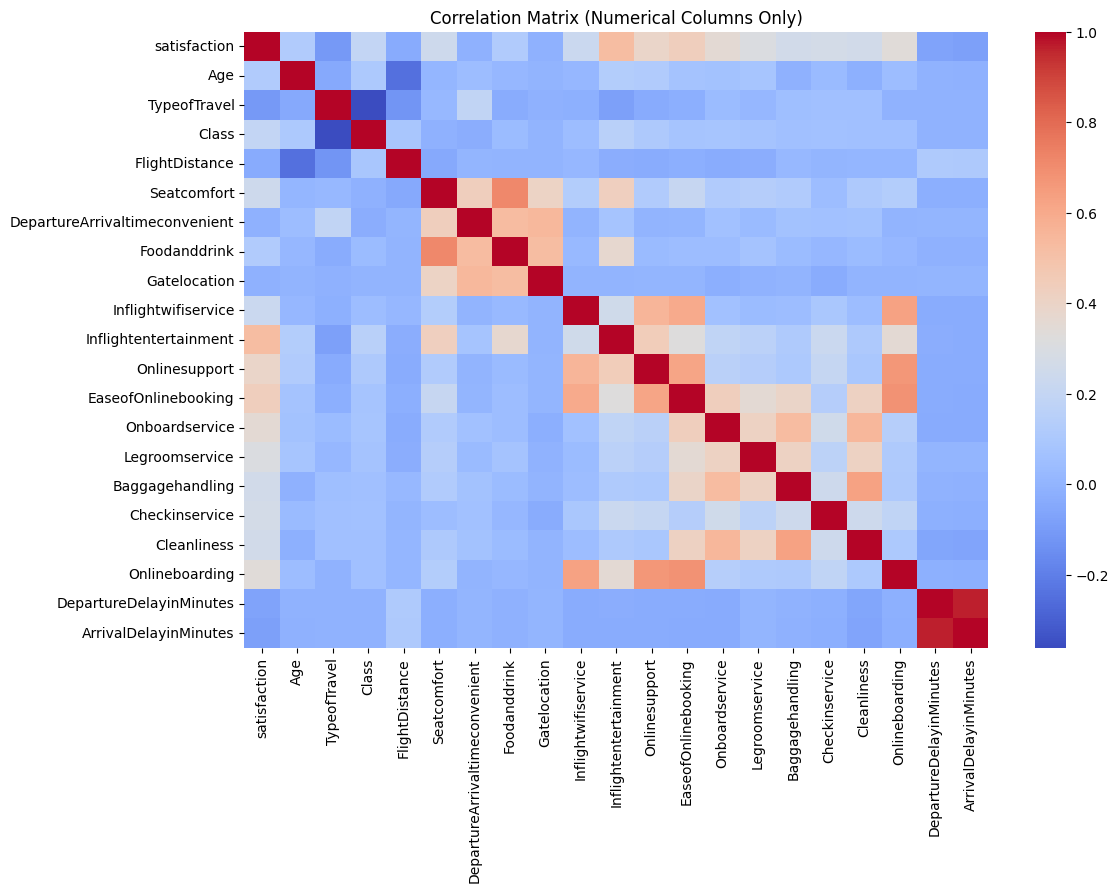

In [65]:
numeric_df = df.select_dtypes(include="number")

#compute correlation
corr = numeric_df.corr()

#plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix (Numerical Columns Only)")
plt.show()

##### What are the highest correlations ?

This is already much more descriptive, and we can now pull correlated values to better understand:

In [66]:
corr

,satisfaction,Age,TypeofTravel,Class,FlightDistance,Seatcomfort,DepartureArrivaltimeconvenient,Foodanddrink,Gatelocation,Inflightwifiservice,...,Onlinesupport,EaseofOnlinebooking,Onboardservice,Legroomservice,Baggagehandling,Checkinservice,Cleanliness,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes
satisfaction,1.000000,0.117971,-0.109239,0.196044,-0.039224,0.242384,-0.015507,0.120677,-0.012071,0.227062,...,0.390143,0.431772,0.352047,0.304928,0.260347,0.266179,0.259330,0.338147,-0.073909,-0.080691
Age,0.117971,1.000000,-0.044808,0.101599,-0.249625,0.008784,0.039055,0.015749,-0.000547,0.013965,...,0.121201,0.071594,0.066704,0.083762,-0.015452,0.031845,-0.018271,0.037973,-0.009041,-0.011248
TypeofTravel,-0.109239,-0.044808,1.000000,-0.361315,-0.122762,0.016839,0.191525,-0.031751,-0.013801,-0.019321,...,-0.039385,-0.025790,0.035899,0.013896,0.048421,0.057253,0.058405,-0.009368,-0.005913,-0.005830
Class,0.196044,0.101599,-0.361315,1.000000,0.089542,-0.010830,-0.029966,0.035502,-0.003515,0.038401,...,0.108194,0.078244,0.084416,0.070190,0.057893,0.063706,0.055853,0.058035,-0.005820,-0.007754
FlightDistance,-0.039224,-0.249625,-0.122762,0.089542,1.000000,-0.042409,0.001350,-0.004649,-0.002409,0.012230,...,-0.032022,-0.022299,-0.032559,-0.030316,0.019768,0.002456,0.009432,0.009604,0.112555,0.110103
Seatcomfort,0.242384,0.008784,0.016839,-0.010830,-0.042409,1.000000,0.434951,0.715997,0.405300,0.129131,...,0.120278,0.211531,0.121149,0.136136,0.118489,0.041214,0.108475,0.130396,-0.023817,-0.025506
DepartureArrivaltimeconvenient,-0.015507,0.039055,0.191525,-0.029966,0.001350,0.434951,1.000000,0.527381,0.544259,-0.001974,...,-0.000546,0.001755,0.060446,0.029422,0.067396,0.062794,0.067126,-0.000623,0.004395,0.002599
Foodanddrink,0.120677,0.015749,-0.031751,0.035502,-0.004649,0.715997,0.527381,1.000000,0.523328,0.025917,...,0.028554,0.041189,0.038646,0.074161,0.036370,0.011898,0.033416,0.013587,-0.013433,-0.014881
Gatelocation,-0.012071,-0.000547,-0.013801,-0.003515,-0.002409,0.405300,0.544259,0.523328,1.000000,-0.004086,...,0.002908,0.001442,-0.025132,-0.007407,-0.000401,-0.031859,-0.001705,-0.003043,0.003962,0.003640
Inflightwifiservice,0.227062,0.013965,-0.019321,0.038401,0.012230,0.129131,-0.001974,0.025917,-0.004086,1.000000,...,0.557340,0.601100,0.060794,0.033589,0.038251,0.092508,0.038263,0.631786,-0.032900,-0.035270


In [67]:
#to read the above correlation table better, we filter to only keep values above a certain arbitrary threshold
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_threshold = 0.2
okay_corr = upper[(upper.abs() >corr_threshold)].stack().sort_values(ascending=False)
print(f"Okay correlations (|corr| > {corr_threshold}):")
print(strong_corr)

Okay correlations (|corr| > 0.2):
DepartureDelayinMinutes  ArrivalDelayinMinutes    0.965291
Age                      FlightDistance          -0.249625
dtype: float64


In [68]:
#and now we print only the strong correlations

#to read the above correlation table better, we filter to only keep values above a certain arbitrary threshold
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_threshold = 0.5
strong_corr = upper[(upper.abs() >corr_threshold)].stack().sort_values(ascending=False)
print(f"Strong correlations (|corr| > {corr_threshold}):")
print(strong_corr)

Strong correlations (|corr| > 0.5):
DepartureDelayinMinutes         ArrivalDelayinMinutes    0.965291
Seatcomfort                     Foodanddrink             0.715997
EaseofOnlinebooking             Onlineboarding           0.684320
Onlinesupport                   Onlineboarding           0.669843
Baggagehandling                 Cleanliness              0.631803
Inflightwifiservice             Onlineboarding           0.631786
Onlinesupport                   EaseofOnlinebooking      0.617489
Inflightwifiservice             EaseofOnlinebooking      0.601100
                                Onlinesupport            0.557340
Onboardservice                  Cleanliness              0.551294
DepartureArrivaltimeconvenient  Gatelocation             0.544259
Onboardservice                  Baggagehandling          0.530448
DepartureArrivaltimeconvenient  Foodanddrink             0.527381
satisfaction                    Inflightentertainment    0.523496
Foodanddrink                    Gateloca

What's interesting to see is that Inflightentertainment and Onlinesupport are perfectly correlated, despite representing two very different aspects of airplane travel.

##### Now, we plot each of the correlated features against one another:

##### Scatterplot

In [69]:
# for (col1, col2), corr_value in strong_corr.items():

#     plt.figure(figsize=(6, 4))
#     sns.scatterplot(data=df, x=col1, y=col2, alpha=0.5)

#     plt.title(f"{col1} vs {col2}\nCorrelation = {corr_value:.3f}", fontsize=12)
#     plt.xlabel(col1)
#     plt.ylabel(col2)

#     plt.tight_layout()
#     plt.show()

##### Lineplot

In [70]:
# for (col1, col2), corr_value in strong_corr.items():

#     plt.figure(figsize=(6, 4))
#     sns.lineplot(data=df, x=col1, y=col2, alpha=0.5)

#     plt.title(f"{col1} vs {col2}\nCorrelation = {corr_value:.3f}", fontsize=12)
#     plt.xlabel(col1)
#     plt.ylabel(col2)

#     plt.tight_layout()
#     plt.show()

---

## Part 2: Customer Segmentation (Clustering)

We apply multiple clustering methods to identify distinct customer profiles:

- **2.1 Data Preparation**: Feature scaling and preprocessing
- **2.2 K-Means**: Centroid-based clustering with elbow/silhouette analysis
- **2.3 Hierarchical**: Dendrogram visualization
- **2.4 PCA → UMAP → HDBSCAN**: Dimension reduction pipeline (main method)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Patch
import hdbscan
import umap

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Patch
import hdbscan
import umap

/Users/othocs/Desktop/AIDAMS/Semester 1/Business Data /groupProject/Business_data_science_final_project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
df['CustomerType'] = df['CustomerType'].map({'disloyal Customer': 0, 'Loyal Customer': 1}).astype('int')
df['ArrivalDelayinMinutes'] = df['ArrivalDelayinMinutes'].fillna(df['ArrivalDelayinMinutes'].median())
print(f"Missing values after imputation: {df['ArrivalDelayinMinutes'].isna().sum()}")

Missing values after imputation: 0


In [73]:
features_for_clustering = df.drop(columns=['satisfaction', 'ArrivalDelayinMinutes'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)

print(f"Features: {list(features_for_clustering.columns)}")
print(f"Shape: {X_scaled.shape}")

Features: ['CustomerType', 'Age', 'TypeofTravel', 'Class', 'FlightDistance', 'Seatcomfort', 'DepartureArrivaltimeconvenient', 'Foodanddrink', 'Gatelocation', 'Inflightwifiservice', 'Inflightentertainment', 'Onlinesupport', 'EaseofOnlinebooking', 'Onboardservice', 'Legroomservice', 'Baggagehandling', 'Checkinservice', 'Cleanliness', 'Onlineboarding', 'DepartureDelayinMinutes']
Shape: (129880, 20)


### 2.2 Method 1: K-Means Clustering

K-Means partitions data into k clusters by minimizing within-cluster variance. We use the elbow method and silhouette score to find optimal k.

### Determining Optimal Number of Clusters

We use two methods:
1. **Elbow Method**: Look for the "elbow" where inertia stops decreasing rapidly
2. **Silhouette Score**: Higher score indicates better-defined clusters

In [74]:
k_range = range(2, 11)
inertias = []
silhouette_scores = []

np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled), size=40000, replace=False)
X_sample = X_scaled[sample_idx]

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_sample, kmeans.labels_))
    print(f"k={k}: Inertia={kmeans.inertia_:.0f}, Silhouette={silhouette_scores[-1]:.3f}")

k=2: Inertia=689385, Silhouette=0.146
k=3: Inertia=636729, Silhouette=0.111
k=4: Inertia=598269, Silhouette=0.110
k=5: Inertia=572181, Silhouette=0.113
k=6: Inertia=549134, Silhouette=0.111
k=7: Inertia=528958, Silhouette=0.116
k=8: Inertia=512798, Silhouette=0.117
k=9: Inertia=498665, Silhouette=0.112
k=10: Inertia=488190, Silhouette=0.114


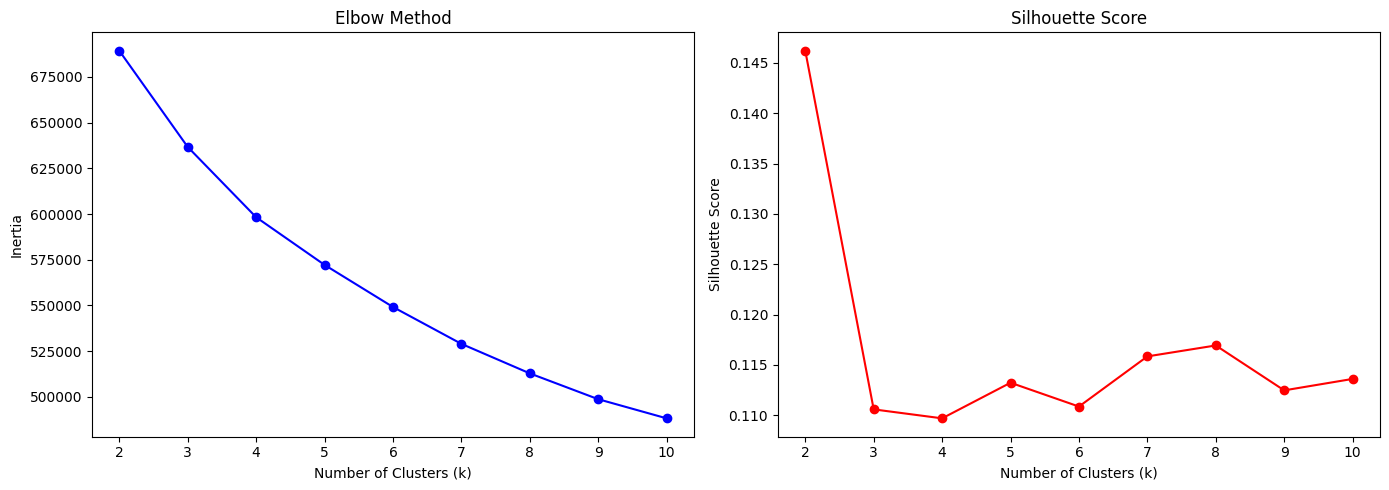


Optimal k based on Silhouette Score: 2


In [75]:
# Plot Elbow Method and Silhouette Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score')

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on Silhouette Score: {optimal_k}")

### Applying K-Means Clustering

Based on our analysis, we'll use k=3 to identify customer segments (Promoters, Passives, Detractors).

In [76]:
# Apply K-Means with k=3 on full dataset
n_clusters = 5
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans_final.fit_predict(X_scaled)

# Cluster distribution
print("Cluster Distribution:")
print(df['cluster'].value_counts().sort_index())

Cluster Distribution:
cluster
0    25341
1    33564
2    30914
3    26005
4    14056
Name: count, dtype: int64


### Cluster Profiling

Let's analyze each cluster to understand customer characteristics and validate with satisfaction rates.

Satisfaction Rate per Cluster:
  Cluster 0: 37.0% satisfied
  Cluster 1: 80.1% satisfied
  Cluster 2: 86.8% satisfied
  Cluster 3: 20.4% satisfied
  Cluster 4: 19.2% satisfied


/var/folders/l3/rrp15v3x6v3gbjzj9z3rsv100000gn/T/ipykernel_53016/497266792.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_satisfaction.index, y=cluster_satisfaction.values, palette='viridis')


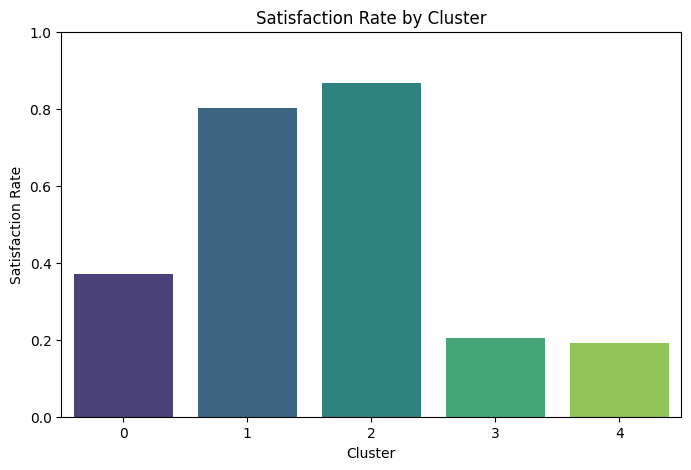

In [77]:
# Satisfaction rate per cluster
cluster_satisfaction = df.groupby('cluster')['satisfaction'].mean()
print("Satisfaction Rate per Cluster:")
for cluster, rate in cluster_satisfaction.items():
    print(f"  Cluster {cluster}: {rate:.1%} satisfied")

# Visualize satisfaction by cluster
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_satisfaction.index, y=cluster_satisfaction.values, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Satisfaction Rate')
plt.title('Satisfaction Rate by Cluster')
plt.ylim(0, 1)
plt.show()

In [78]:
# Cluster profiles - mean values for each feature
cluster_profiles = df.groupby('cluster')[features_for_clustering.columns].mean()
print("Cluster Profiles (Mean Values):")
cluster_profiles.T

Cluster Profiles (Mean Values):


cluster,0,1,2,3,4
CustomerType,0.986386,0.961328,0.998609,0.675370,0.028742
Age,44.023243,41.359254,43.155949,33.500788,29.298307
TypeofTravel,0.307723,0.393964,0.264217,0.407845,0.027888
Class,0.661852,0.649952,0.804199,0.448568,0.417544
FlightDistance,1844.069058,1912.402783,1994.651711,2169.144511,2017.337863
Seatcomfort,2.661971,4.209242,2.025005,2.391886,2.499929
DepartureArrivaltimeconvenient,2.887850,4.238887,2.044575,3.043222,2.178785
Foodanddrink,2.796890,4.126624,1.887300,2.611805,2.473748
Gatelocation,2.920524,4.045257,1.928511,2.957893,2.993312
Inflightwifiservice,3.375360,3.683232,3.679983,1.688714,3.924303


### PCA Visualization

Reduce dimensionality to 2D for visualization of clusters.

Explained variance ratio: [0.19934121 0.12741665]
Total variance explained: 32.7%


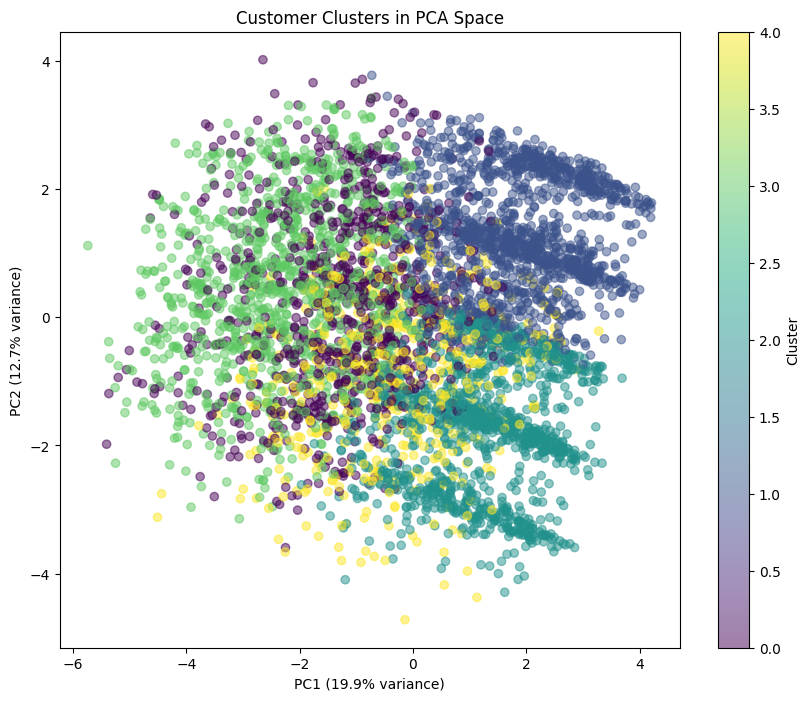

In [79]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.1%}")

# Scatter plot of clusters in PCA space (use sample for faster plotting)
sample_size = 5000
sample_indices = np.random.choice(len(X_pca), size=sample_size, replace=False)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[sample_indices, 0], X_pca[sample_indices, 1], 
                      c=df['cluster'].iloc[sample_indices], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Clusters in PCA Space')
plt.show()

### 2.3 Method 2: Hierarchical Clustering

Hierarchical clustering builds a tree of clusters. We visualize with a dendrogram to understand the cluster hierarchy.

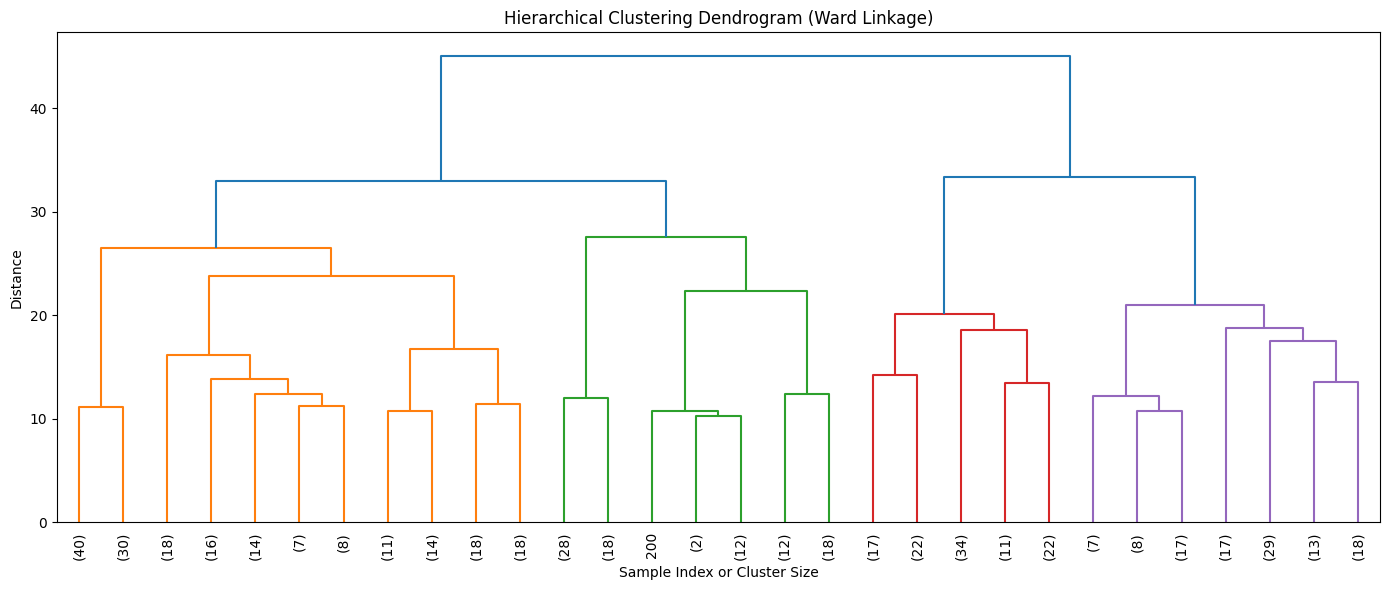

In [80]:
dendrogram_sample_size = 500
np.random.seed(42)
dendrogram_indices = np.random.choice(len(X_scaled), size=dendrogram_sample_size, replace=False)
X_dendrogram = X_scaled[dendrogram_indices]

linkage_matrix = linkage(X_dendrogram, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

### 2.4 Method 3: PCA → UMAP → HDBSCAN Pipeline (Main Method)

This is our recommended approach combining:
1. **PCA**: Remove noise and reduce dimensionality while preserving 95% variance
2. **UMAP**: Preserve local and global structure for better cluster separation
3. **HDBSCAN**: Density-based clustering that automatically finds the number of clusters

In [81]:
pca_full = PCA(n_components=0.95, random_state=42)
X_pca_reduced = pca_full.fit_transform(X_scaled)

print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"PCA dimensions (95% variance): {X_pca_reduced.shape[1]}")
print(f"Explained variance per component: {pca_full.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_full.explained_variance_ratio_):.1%}")

Original dimensions: 20
PCA dimensions (95% variance): 17
Explained variance per component: [0.19934121 0.12741665 0.1075985  0.07660653 0.06984081 0.05657979
 0.04921026 0.04714783 0.04348099 0.03308228 0.03148358 0.02428214
 0.02334145 0.01978078 0.0194539  0.01824161 0.01658836]
Total variance explained: 96.3%


In [82]:
print("Fitting UMAP...")

umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

umap_sample_size = 30000
np.random.seed(42)
umap_sample_idx = np.random.choice(len(X_pca_reduced), size=umap_sample_size, replace=False)
X_umap = umap_reducer.fit_transform(X_pca_reduced[umap_sample_idx])

print(f"UMAP output shape: {X_umap.shape}")

Fitting UMAP...


/Users/othocs/Desktop/AIDAMS/Semester 1/Business Data /groupProject/Business_data_science_final_project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP output shape: (30000, 2)


In [83]:
clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=1000, min_samples=10)
umap_hdbscan_labels = clusterer_umap.fit_predict(X_umap)

n_clusters_umap = len(set(umap_hdbscan_labels)) - (1 if -1 in umap_hdbscan_labels else 0)
n_noise_umap = list(umap_hdbscan_labels).count(-1)

print(f"HDBSCAN Results:")
print(f"  Clusters found: {n_clusters_umap}")
print(f"  Noise points: {n_noise_umap} ({n_noise_umap/len(umap_hdbscan_labels)*100:.1f}%)")
print(f"\nCluster distribution:")
print(pd.Series(umap_hdbscan_labels).value_counts().sort_index())

/Users/othocs/Desktop/AIDAMS/Semester 1/Business Data /groupProject/Business_data_science_final_project/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/othocs/Desktop/AIDAMS/Semester 1/Business Data /groupProject/Business_data_science_final_project/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN Results:
  Clusters found: 8
  Noise points: 767 (2.6%)

Cluster distribution:
-1     767
 0    5494
 1    9015
 2    1735
 3    3244
 4    1967
 5    1533
 6    1218
 7    5027
Name: count, dtype: int64


In [84]:
umap_sample_df = df.iloc[umap_sample_idx].copy()
umap_sample_df['umap_cluster'] = umap_hdbscan_labels

clusters_only_umap = umap_sample_df[umap_sample_df['umap_cluster'] != -1]
umap_satisfaction = clusters_only_umap.groupby('umap_cluster')['satisfaction'].mean()

print("Satisfaction Rate per Cluster:")
for cluster, rate in umap_satisfaction.items():
    count = (umap_sample_df['umap_cluster'] == cluster).sum()
    print(f"  Cluster {cluster}: {rate:.1%} satisfied (n={count})")

if n_noise_umap > 0:
    noise_sat = umap_sample_df[umap_sample_df['umap_cluster'] == -1]['satisfaction'].mean()
    print(f"  Noise (-1): {noise_sat:.1%} satisfied (n={n_noise_umap})")

Satisfaction Rate per Cluster:
  Cluster 0: 24.3% satisfied (n=5494)
  Cluster 1: 48.3% satisfied (n=9015)
  Cluster 2: 30.7% satisfied (n=1735)
  Cluster 3: 97.5% satisfied (n=3244)
  Cluster 4: 46.3% satisfied (n=1967)
  Cluster 5: 92.0% satisfied (n=1533)
  Cluster 6: 53.9% satisfied (n=1218)
  Cluster 7: 74.5% satisfied (n=5027)
  Noise (-1): 47.7% satisfied (n=767)


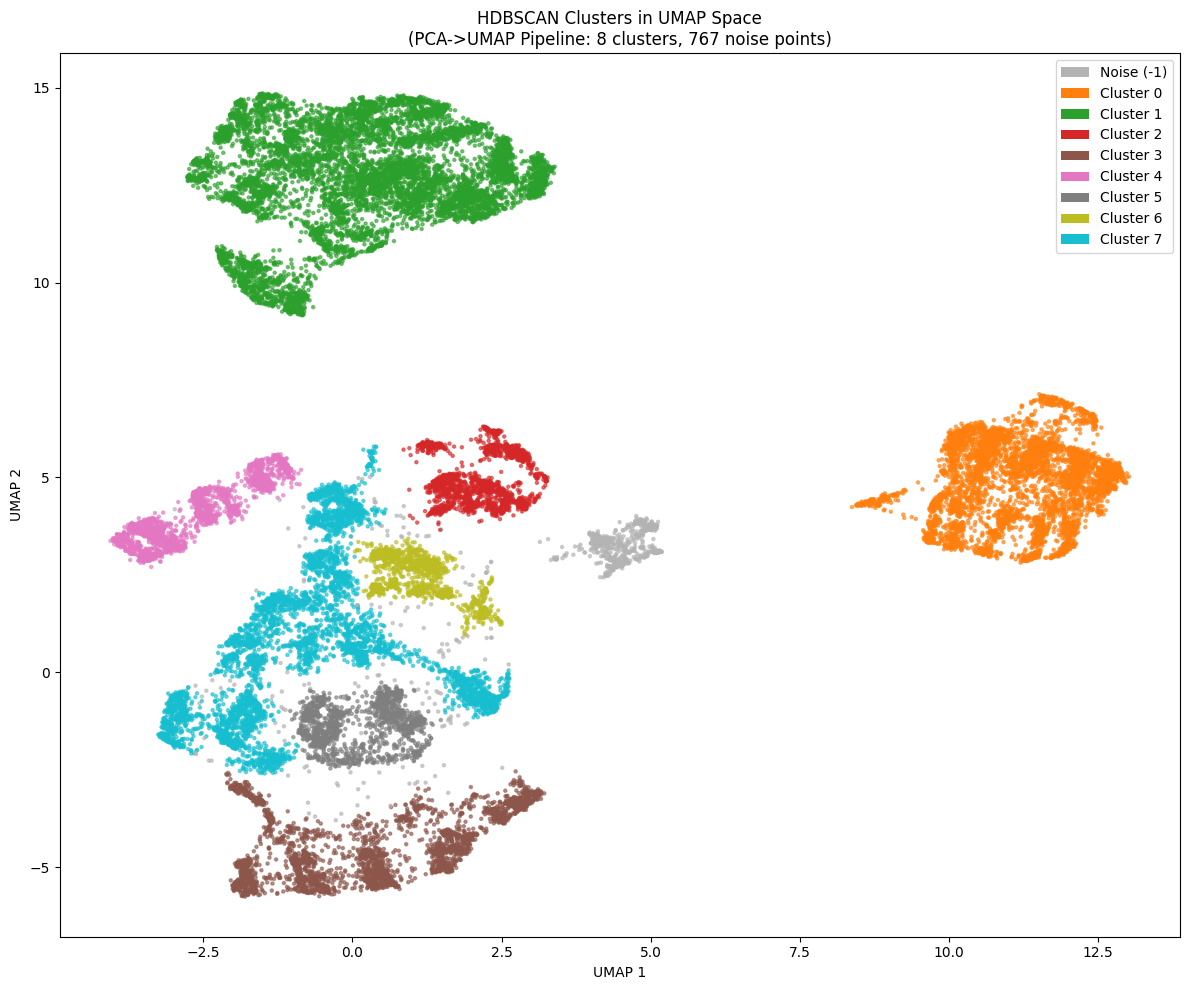

In [85]:
unique_umap_labels = np.unique(umap_hdbscan_labels)
umap_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_umap_labels)))
umap_color_map = {label: umap_colors[i] if label != -1 else (0.7, 0.7, 0.7, 1) 
                  for i, label in enumerate(unique_umap_labels)}
umap_point_colors = [umap_color_map[label] for label in umap_hdbscan_labels]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=umap_point_colors, alpha=0.6, s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'HDBSCAN Clusters in UMAP Space\n(PCA->UMAP Pipeline: {n_clusters_umap} clusters, {n_noise_umap} noise points)')

legend_elements = [Patch(facecolor=umap_color_map[label], 
                         label=f'Cluster {label}' if label != -1 else 'Noise (-1)') 
                   for label in sorted(unique_umap_labels)]
plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

### 2.5 Cluster Analysis & Business Insights

Now we analyze the HDBSCAN clusters to extract actionable business insights.

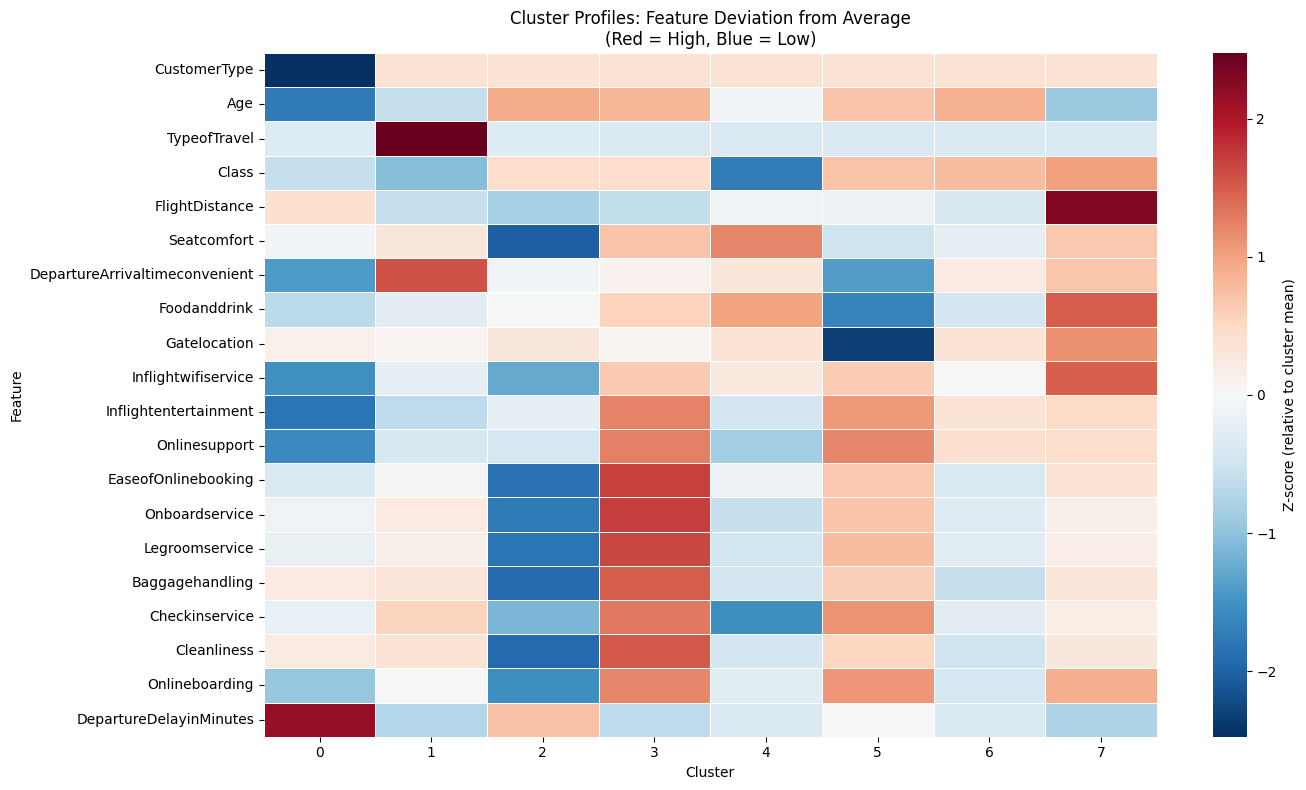

In [86]:
clusters_df = umap_sample_df[umap_sample_df['umap_cluster'] != -1].copy()

feature_cols = [col for col in features_for_clustering.columns]
cluster_means = clusters_df.groupby('umap_cluster')[feature_cols].mean()

cluster_means_normalized = (cluster_means - cluster_means.mean()) / cluster_means.std()

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_means_normalized.T, cmap='RdBu_r', center=0, 
            annot=False, fmt='.1f', linewidths=0.5,
            cbar_kws={'label': 'Z-score (relative to cluster mean)'})
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.title('Cluster Profiles: Feature Deviation from Average\n(Red = High, Blue = Low)')
plt.tight_layout()
plt.show()

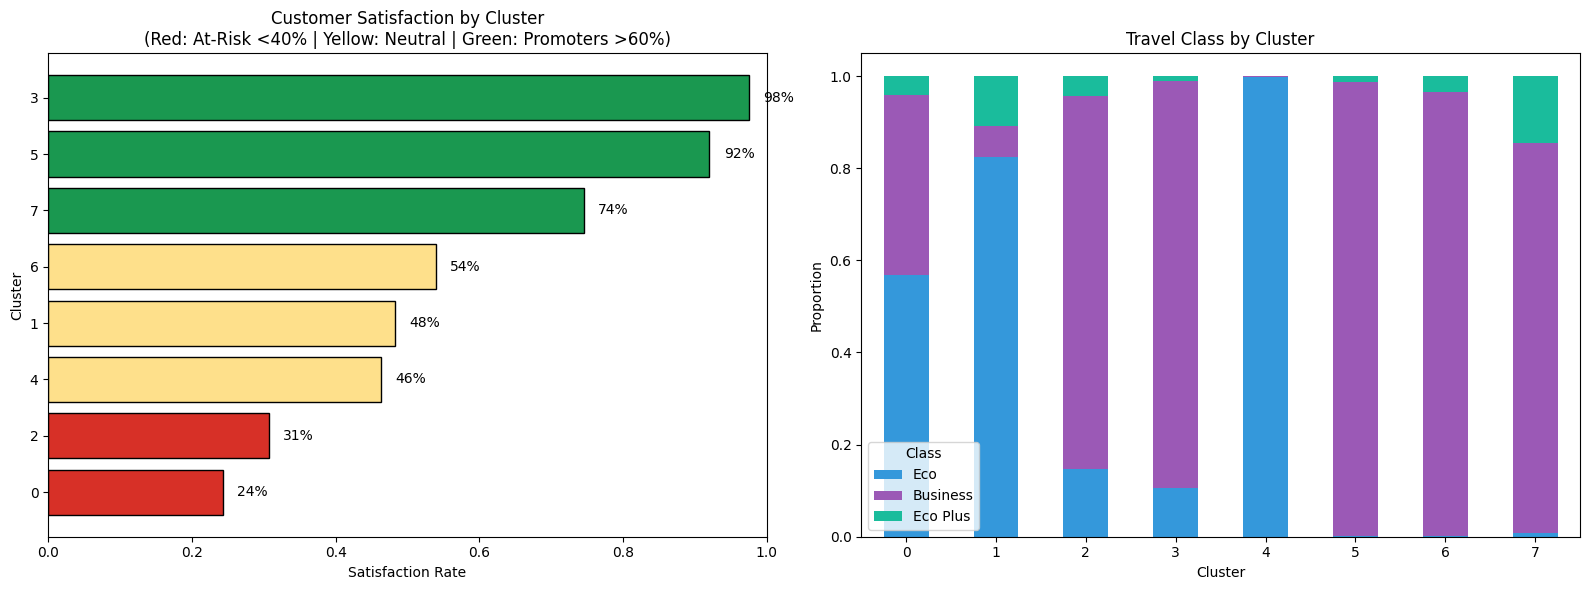


Cluster Risk Assessment:
  Cluster 0: 24.3% satisfied (5494 customers) - AT-RISK
  Cluster 2: 30.7% satisfied (1735 customers) - AT-RISK
  Cluster 4: 46.3% satisfied (1967 customers) - NEUTRAL
  Cluster 1: 48.3% satisfied (9015 customers) - NEUTRAL
  Cluster 6: 53.9% satisfied (1218 customers) - NEUTRAL
  Cluster 7: 74.5% satisfied (5027 customers) - PROMOTER
  Cluster 5: 92.0% satisfied (1533 customers) - PROMOTER
  Cluster 3: 97.5% satisfied (3244 customers) - PROMOTER


In [87]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

satisfaction_by_cluster = clusters_df.groupby('umap_cluster').agg({
    'satisfaction': ['mean', 'count']
}).round(3)
satisfaction_by_cluster.columns = ['Satisfaction Rate', 'Size']
satisfaction_by_cluster = satisfaction_by_cluster.sort_values('Satisfaction Rate', ascending=True)

colors = ['#d73027' if x < 0.4 else '#fee08b' if x < 0.6 else '#1a9850' 
          for x in satisfaction_by_cluster['Satisfaction Rate']]

bars = axes[0].barh(satisfaction_by_cluster.index.astype(str), 
                    satisfaction_by_cluster['Satisfaction Rate'], 
                    color=colors, edgecolor='black')
axes[0].set_xlabel('Satisfaction Rate')
axes[0].set_ylabel('Cluster')
axes[0].set_title('Customer Satisfaction by Cluster\n(Red: At-Risk <40% | Yellow: Neutral | Green: Promoters >60%)')
axes[0].set_xlim(0, 1)

for bar, rate in zip(bars, satisfaction_by_cluster['Satisfaction Rate']):
    axes[0].text(rate + 0.02, bar.get_y() + bar.get_height()/2, 
                 f'{rate:.0%}', va='center', fontsize=10)

class_comp = clusters_df.groupby('umap_cluster')['Class'].value_counts(normalize=True).unstack(fill_value=0)
class_comp.columns = ['Eco', 'Business', 'Eco Plus']
class_comp.plot(kind='bar', stacked=True, ax=axes[1], color=['#3498db', '#9b59b6', '#1abc9c'])
axes[1].set_title('Travel Class by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Class')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\nCluster Risk Assessment:")
for cluster, row in satisfaction_by_cluster.iterrows():
    status = "AT-RISK" if row['Satisfaction Rate'] < 0.4 else "NEUTRAL" if row['Satisfaction Rate'] < 0.6 else "PROMOTER"
    print(f"  Cluster {cluster}: {row['Satisfaction Rate']:.1%} satisfied ({int(row['Size'])} customers) - {status}")

In [88]:
summary_data = []

for cluster in sorted(clusters_df['umap_cluster'].unique()):
    cluster_data = clusters_df[clusters_df['umap_cluster'] == cluster]
    
    size = len(cluster_data)
    sat_rate = cluster_data['satisfaction'].mean()
    loyal_pct = cluster_data['CustomerType'].mean()
    business_class_pct = (cluster_data['Class'] == 1).mean()
    business_travel_pct = (cluster_data['TypeofTravel'] == 0).mean()
    avg_age = cluster_data['Age'].mean()
    avg_service = cluster_data[service_features].mean().mean()
    
    if sat_rate > 0.8 and loyal_pct > 0.8:
        name = "Premium Loyalists"
    elif sat_rate > 0.6 and business_class_pct > 0.5:
        name = "Business Elite"
    elif sat_rate < 0.35 and avg_service < 2.5:
        name = "Service Detractors"
    elif sat_rate < 0.35:
        name = "At-Risk Customers"
    elif loyal_pct < 0.3:
        name = "New/Disloyal Flyers"
    elif business_travel_pct > 0.8:
        name = "Frequent Business"
    elif avg_age < 35:
        name = "Young Travelers"
    elif business_class_pct > 0.4 and sat_rate > 0.5:
        name = "Satisfied Professionals"
    else:
        name = "Mixed Segment"
    
    summary_data.append({
        'Cluster': cluster,
        'Segment Name': name,
        'Size': size,
        'Satisfaction': f"{sat_rate:.0%}",
        'Loyal %': f"{loyal_pct:.0%}",
        'Business Class %': f"{business_class_pct:.0%}",
        'Avg Age': f"{avg_age:.0f}",
        'Avg Service Rating': f"{avg_service:.1f}/5"
    })

summary_df = pd.DataFrame(summary_data)
print("CUSTOMER SEGMENTATION SUMMARY")
print(summary_df.to_string(index=False))

NameError: name 'service_features' is not defined